In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from helpers import style
from helpers.afa import adaptive_filter
from itertools import groupby
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from collections import defaultdict
import networkx as nx

from helpers.linkage import mutual_information_smooth
from helpers import nwsim
from helpers.visuals import add_cabinet_periods
from helpers.metrics import *
from helpers.metrics import foote_novelty
import matplotlib.gridspec as gridspec

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()
import cdlib

from helpers.dataloader import load

In [2]:
dists, dat, coltrans, keys = load(zscore_filter=False)

# Modularity

Modularity is the extent to which a network is marked by communities. A rising modularity would be a first indication of topic-level specialization.

In [11]:
## Modularity
def get_mod(v):
    rij, ri, m = mutual_information_smooth(v)
    edf = pd.DataFrame(rij).stack().reset_index()
    edf = edf[edf[0] > 0]
    G = nx.from_pandas_edgelist(df = edf, source = 'level_0', target = 'level_1', edge_attr=0)
    comms = nx.community.louvain_communities(G,weight=0,resolution=2.5)
    return nx.community.quality.modularity(G,communities=comms)

## Density
def get_ds(v):
    rij, ri, m = mutual_information_smooth(v)
    edf = pd.DataFrame(rij).stack().reset_index()
    edf = edf[edf[0] > 0]
    G = nx.from_pandas_edgelist(df = edf, source = 'level_0', target = 'level_1', edge_attr=0)
    return nx.density(G)

In [12]:
df_degree = dists.groupby(dists.index).apply(lambda g: get_ds(g.to_numpy())).reset_index(name='degree')
df_modul = dists.groupby(dists.index).apply(lambda g: get_mod(g.to_numpy())).reset_index(name='modularity')

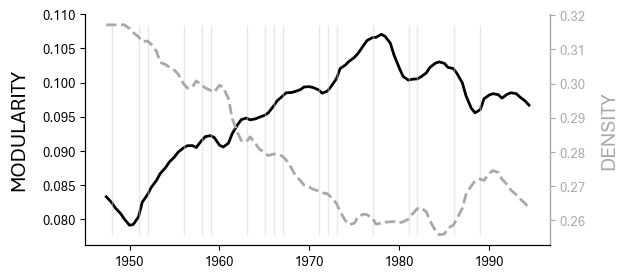

In [13]:
f, a = plt.subplots(1,1,figsize=(6,3))
a.plot(df_modul['index'], adaptive_filter(df_modul.modularity,span=35),color='black',label='Modularity',lw=2)
a.set_ylabel('Modularity'.upper(),color='black',fontsize=15,labelpad=10)
aa = a.twinx()
aa.plot(df_degree['index'], adaptive_filter(df_degree.degree,span=35),color='darkgrey',label='Density',lw=2,linestyle='--')
aa.yaxis.set_label_position("right")
aa.set_ylabel('DENSITY'.upper(),color='darkgrey',fontsize=15,labelpad=10)
aa.spines['right'].set_color('darkgrey')
aa.tick_params(colors='darkgrey')

a.spines['top'].set_alpha(0)
aa.spines['top'].set_alpha(0)

add_cabinet_periods(ax=a,min_time=1948,max_time=1994,text=False,color='lightgrey',linestyle='-')

plt.savefig('figs/mod-degs.png',dpi=400,bbox_inches='tight')
plt.show()

## Community Stability

In [3]:
from helpers.pathtools import *
from cdlib.evaluation import normalized_mutual_information, adjusted_rand_index, jaccard_index
from helpers.visuals import plot_trend

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy', 'infomap', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [4]:
r = []
networks = {}
size_dicts = {}

for cd,(date, _) in enumerate(dists.groupby(dists.index)):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]

    sizes = _.mean()
    sizes.index = sizes.index.astype(int).map(keys)
    sizes = sizes.to_dict()
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr=['pmi'])
    networks[date] = g
    size_dicts[cd] = list(sizes.items())

tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.5, louvain_res=3, verbose=False)
cst1 = pd.DataFrame([{"date":d,"nmi":sid} for d,sid in zip(sorted(networks.keys()),tc.clustering_stability_trend(method=normalized_mutual_information))])

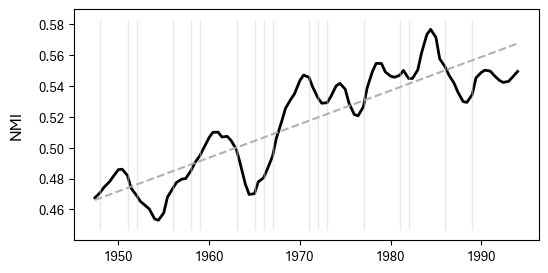

In [10]:
f,a = plt.subplots(1,1,figsize=(6,3))

y = adaptive_filter(cst1.nmi,span=35)
x = cst1.date
a.plot(x,y,color='black',lw=2)

add_cabinet_periods(ax=a,min_time=1948,max_time=1994,text=False,color='lightgrey',linestyle='-')
plot_trend(x=cst1.date,y=cst1.nmi,color='darkgrey',ls='--',ax=a,alpha=.9)
a.set_ylabel('NMI',labelpad=10)
plt.subplots_adjust(hspace=.5)
plt.savefig('figs/clustering-stability.png',dpi=400,bbox_inches='tight')
plt.show()